In [1]:
#basemodel on ginsburg batch-size=32
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split

!module load cuda11.0/toolkit cuda11.0/blas cudnn8.0-cuda11.0

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-09-15 15:32:01.560892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  1


2021-09-15 15:35:43.420931: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 15:35:43.522021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-15 15:35:43.754616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2021-09-15 15:35:43.754663: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-15 15:35:45.721759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-15 15:35:45.721826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-0

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.config.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image,preprocess_image

In [4]:
dir_name="../data/data1"
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
chl_images=preprocess_image(chl.Chl.data)
mld_images=preprocess_image(mld.MLD.data)
sss_images=preprocess_image(sss.SSS.data)
sst_images=preprocess_image(sst.SST.data)
xco2_images=preprocess_image(xco2.XCO2.data,xco2=True)
pco2_images=preprocess_image(pco2.pCO2.data,pco2=True)


In [6]:
xco2_images.shape, pco2_images.shape #dimensions

((421, 180, 360, 1), (421, 180, 360, 1))

In [7]:
pco2.pCO2.data.max(), pco2.pCO2.data.min(), pco2.pCO2.data.std() #pco2 information

(831.1136616134033, 0.0, 171.05473677144028)

In [8]:
X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

In [9]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

In [17]:
from functools import partial
from tensorflow import keras

DefaultConv3D = partial(keras.layers.Conv3D,
                        kernel_size=3,activation='relu', padding="SAME")

base_model = keras.models.Sequential([
    DefaultConv3D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv3D(filters=64),
    keras.layers.MaxPooling3D(pool_size=3),
    DefaultConv3D(filters=128),
    DefaultConv3D(filters=128),
    keras.layers.Dropout(0.3),
    keras.layers.UpSampling3D(size=(1,3,3)),
    DefaultConv3D(filters=64),
    DefaultConv3D(filters=2),
    DefaultConv3D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 5, 180, 360, 64)   1792      
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 5, 180, 360, 64)   110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 60, 120, 64)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 60, 120, 128)   221312    
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 1, 60, 120, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 60, 120, 128)   0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 1, 180, 360, 128) 

In [18]:
base_model.compile(loss="mean_squared_error", optimizer="nadam", metrics=["mean_squared_error"])


In [20]:
model_path="../models/base_model/base_model.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=32,callbacks=callbacks)


Epoch 1/100
14/14 [==============================] - 55s 3s/step - loss: 30439.9375 - mean_squared_error: 30439.9375 - val_loss: 42560.6289 - val_mean_squared_error: 42560.6250
INFO:tensorflow:Assets written to: ../models/base_model/assets
Epoch 2/100
14/14 [==============================] - 34s 2s/step - loss: 26083.3105 - mean_squared_error: 26083.3047 - val_loss: 20008.2949 - val_mean_squared_error: 20008.2949
INFO:tensorflow:Assets written to: ../models/base_model/assets
Epoch 3/100
14/14 [==============================] - 34s 2s/step - loss: 15631.5732 - mean_squared_error: 15631.5723 - val_loss: 9393.6309 - val_mean_squared_error: 9393.6318
INFO:tensorflow:Assets written to: ../models/base_model/assets
Epoch 4/100
14/14 [==============================] - 34s 2s/step - loss: 8044.3823 - mean_squared_error: 8044.3833 - val_loss: 6591.9502 - val_mean_squared_error: 6591.9507
INFO:tensorflow:Assets written to: ../models/base_model/assets
Epoch 5/100
14/14 [===========================

In [21]:
predicted_image=base_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 116ms/step


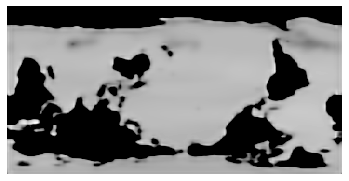

In [22]:
plot_image(np.squeeze(predicted_image[1]))

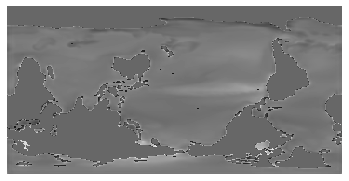

In [23]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

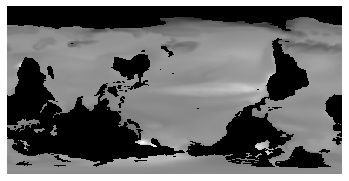

In [25]:
plot_image(np.squeeze(pco2_images[419:421][1]))